In [1]:
import math
import random
import torch
import numpy as np
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split





In [2]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  

print(dev)

cuda:0


In [3]:
def valuation(type_offender, type_defender, t):
    v_1 = type_offender * (t - t ** 2 / 2)
    v_2 = type_defender * (1 - t)
    
    return v_1, v_2


def loss_function(value):
    return -value


In [4]:
class Net(torch.nn.Module):
    def __init__(self):

        super(Net, self).__init__()
        self.u_offender = Variable(torch.Tensor([1.0]), requires_grad=False).cuda() 
        self.u_defender = torch.nn.Parameter(torch.Tensor([3.75]), requires_grad=False).cuda() 
        num_input=1
        num_hidden=20
        num_output=1
        
        self.hidden_0 = torch.nn.Linear(num_input, num_hidden)
        self.hidden_1 = torch.nn.Linear(num_hidden, num_hidden)
        self.hidden_2 = torch.nn.Linear(num_hidden, num_hidden)
        self.hidden_3 = torch.nn.Linear(num_hidden, num_hidden)
        self.output   = torch.nn.Linear(num_hidden, num_output)
        
        

    def forward(self, x, type_offender, type_defender): # type_offender val_offender   ;  type_defender val_defender

        h1 = torch.relu_(self.hidden_0(x))
        h2 = torch.relu_(self.hidden_1(h1))
        h3 = torch.sigmoid(self.hidden_2(h2))
        h4 = torch.sigmoid(self.hidden_3(h3))
        ao = self.output(h4)

        value_offender, value_defender = valuation(type_offender, type_defender, x)
        temp_val_offender = (value_offender * (self.u_offender).cuda()).cuda() 
        temp_val_defender = (value_defender * (self.u_defender).cuda()).cuda()
        
        
        val_offender = temp_val_offender + ao
        val_defender = temp_val_defender + ao
        #print(o.grad_fn,temp_val_defender.grad_fn)
        #print(val_offender)
        
        max_offender, max_t_offender = val_offender.max(0)
        max_defender, max_t_defender = val_defender.max(0)
        
        
        
        #print("max_offender: " ,max_offender,max_offender.grad)
        
        val_sum = val_offender + val_defender - ao
        max_val, t_end = val_sum.max(0) 

        end_val_offender = val_offender[int(t_end)].cuda()
        end_val_defender = val_defender[int(t_end)].cuda()
        pay_offender = (max_defender - end_val_defender) / (self.u_offender).cuda()
        pay_defender = (max_offender - end_val_offender) / (self.u_defender).cuda()
        
#         if((max_defender - end_val_defender) / self.u_offender > value_offender[int(t_end)]):
#             print("error: payment offender",(max_defender - end_val_defender) / self.u_offender,value_offender[int(t_end)]);
#         if((max_offender - end_val_offender) / self.u_defender > value_defender[int(t_end)]):
#             print("error: payment defender",(max_offender - end_val_offender) / self.u_defender,value_defender[int(t_end)]);
        
        payment = pay_offender + pay_defender

        return payment, ao, x[int(t_end)], self.u_offender ,self.u_defender




In [5]:
def weight_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)
        

In [6]:
random.seed(2000)
torch.manual_seed(256)
time_frame = np.linspace(0, 1, 101)
time_frame = np.expand_dims(time_frame, axis=1)

time_frame = torch.from_numpy(time_frame).cuda()
time_frame = time_frame.type(torch.float32)
time_frame.requires_gard = False
net  = Net()
net.apply(weight_init)
print(time_frame)

tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900],
        [0.1000],
        [0.1100],
        [0.1200],
        [0.1300],
        [0.1400],
        [0.1500],
        [0.1600],
        [0.1700],
        [0.1800],
        [0.1900],
        [0.2000],
        [0.2100],
        [0.2200],
        [0.2300],
        [0.2400],
        [0.2500],
        [0.2600],
        [0.2700],
        [0.2800],
        [0.2900],
        [0.3000],
        [0.3100],
        [0.3200],
        [0.3300],
        [0.3400],
        [0.3500],
        [0.3600],
        [0.3700],
        [0.3800],
        [0.3900],
        [0.4000],
        [0.4100],
        [0.4200],
        [0.4300],
        [0.4400],
        [0.4500],
        [0.4600],
        [0.4700],
        [0.4800],
        [0.4900],
        [0.5000],
        [0.5100],
        [0.5200],
        [0.5300],
        [0.5400],
        [0

[391.1958048    8.07743806]
[[271.69199845  12.05608554]
 [ 85.35414143   6.78185943]
 [ 92.12115161   8.22734879]
 ...
 [303.15368136   3.59778968]
 [191.24357187   7.38312562]
 [163.77016144   3.63757603]]
[271.69199845  85.35414143  92.12115161 ... 303.15368136 191.24357187
 163.77016144]


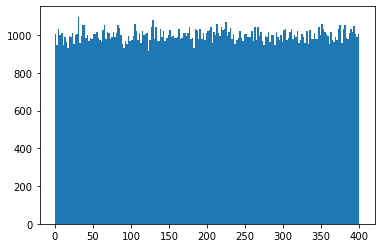

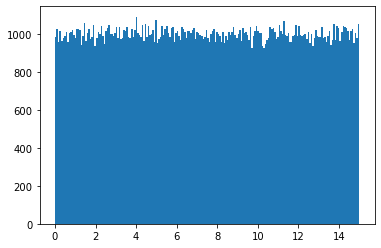

180000
[array([101.62302154,  14.51348007]), array([358.69276408,   2.38606712]), array([295.40609566,  13.84184206]), array([257.09125878,   6.59259653]), array([62.25040933, 11.64733725]), array([182.99564195,   7.06279225]), array([172.6268948,   3.5526404]), array([341.18964999,  11.74316758]), array([248.70156042,   8.16909651]), array([28.8651362 ,  0.34737068]), array([297.68555209,  10.42705906]), array([106.92333513,   8.71202509]), array([30.9082895 ,  6.52370323]), array([239.77081892,  11.37041653]), array([26.98250393,  7.51637857]), array([80.4731585 ,  9.13683528]), array([314.53090381,   3.10470423]), array([364.68497296,  11.41270698]), array([275.47118998,  10.33522824]), array([187.55454241,   4.51921096]), array([213.08101949,   6.58091709]), array([345.86406392,   5.45856074]), array([261.93782665,   8.83745731]), array([379.09048063,  14.79072811]), array([346.61899147,  12.86602716]), array([13.68086609,  9.10215798]), array([228.88007388,   6.29833958]), array([

In [7]:
agent_number_n=2
seed = 7
np.random.seed(seed)
exec(open('distribution1item_uniform.py').read())

X_train,  X_test = train_test_split(value_list, test_size=0.1, random_state=seed)

dataset_size = len(X_train)
print(dataset_size)
print(X_train[:100])
print(len(X_test))



In [8]:
index_train=[]
batch_length = int(10)
t_off = np.linspace(0, 400, batch_length)
t_def = np.linspace(0, 15, batch_length)
index_train = []
for i in range(batch_length):
    for j in range(batch_length):
        index_train.append([t_off[i], t_def[j]])

In [9]:
net = torch.load("AMA_net_small_1")

net.u_defender = torch.nn.Parameter(torch.Tensor([3.7]), requires_grad=True)

In [10]:
net.to(dev)

Net(
  (hidden_0): Linear(in_features=1, out_features=20, bias=True)
  (hidden_1): Linear(in_features=20, out_features=20, bias=True)
  (hidden_2): Linear(in_features=20, out_features=20, bias=True)
  (hidden_3): Linear(in_features=20, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=1, bias=True)
)

[289.69697997   1.64751962]
[[ 68.9027889    3.38049174]
 [379.06569119  10.11314656]
 [  7.96475746  13.89662473]
 ...
 [168.62979467   2.60974413]
 [135.75741733   8.18651573]
 [ 28.64741318   9.62004914]]
[ 68.9027889  379.06569119   7.96475746 ... 168.62979467 135.75741733
  28.64741318]


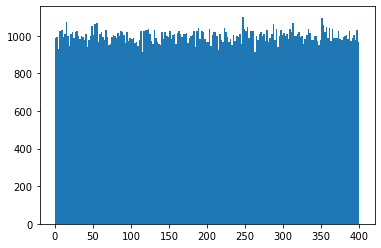

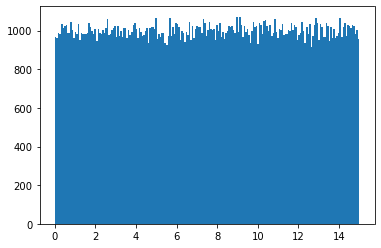

In [11]:
agent_number_n=2
exec(open('distribution1item_uniform.py').read())


In [12]:

#optimizer = opt.RMSprop(net.parameters(), lr=0.00001)
optimizer = opt.SGD(net.parameters(), lr=0.005)
#optimizer = opt.Adam(net.parameters(), lr=0.001)

batch_size = 512
echo = 5000

In [13]:

for i in range(int(echo)):

    # offender_types = []
    # defender_types = []
    loss_sum = 0
    denominator =0
    """
    for j in range(batch_size):
        offender_types.append(random.randint(0, 400))
        defender_types.append(random.randint(0, 15))
    """
    for j in range(batch_size):
        index_random = random.randint(0,len(X_train)-1)
        pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            X_train[index_random][0], X_train[index_random][1])
        loss_sum += pay
        
        denominator+=1
        
    
    optimizer.zero_grad()
    loss = loss_function(loss_sum / denominator) 
    
    loss.backward()
    
    loss_average=loss_sum[0].data / denominator;

    optimizer.step()
    
    if(loss_average>50.5):
        break;
    
    if i % 100 == 0:
        #offender_types = sum(offender_types) / batch_size
        #defender_types = sum(defender_types) / batch_size
        #print(loss_sum.data)
        #print(offender_types, defender_types, loss_sum)
        #print("curve for o: ",curve)
        print("sum_average: %.5f " % loss_average,'， %.5f' % float(uu_defender))
        #plt.pause(0.03)
    

sum_average: 46.28790  ， 3.71781


loss_sum: 50.74232
tensor([0.9000], device='cuda:0')


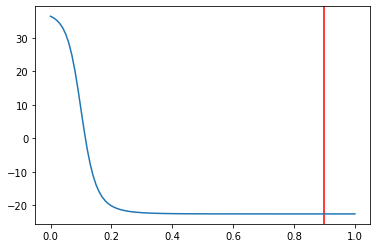

In [14]:
print("loss_sum: %.5f" % -loss)

print(o_star)
plt.cla()
plt.axvline(o_star.cpu().data,color ='red')
plt.plot(time_frame.cpu().data.numpy(), curve_o.cpu().data.numpy())




In [17]:
loss_sum=0
for i in range(len(X_test)):
    pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            X_test[i][0], X_test[i][1])
    loss_sum += float(pay)

print(len(X_test))
print("test_average: %.5f" % (loss_sum/len(X_test) ))

20000
test_average: 47.40454


In [16]:
torch.save(net, "AMA_net_small_2")